### Imports

In [ ]:
import os, urllib.request
import cv2, numpy as np, matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import drawing_styles as mp_styles
from mediapipe.python.solutions import face_mesh_connections as fmc

AttributeError: module 'mediapipe' has no attribute 'solutions'

### Download Mediapipe model and create landmarks

In [ ]:
MODEL_URL = (
    "https://storage.googleapis.com/mediapipe-models/face_landmarker/"
    "face_landmarker/float16/1/face_landmarker.task"
)
MODEL_PATH = "face_landmarker.task"

if not os.path.exists(MODEL_PATH):
    urllib.request.urlretrieve(MODEL_URL, MODEL_PATH)

base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    num_faces=1,
    output_face_blendshapes=False,
    output_facial_transformation_matrixes=False,
)
face_landmarker = vision.FaceLandmarker.create_from_options(options)

W0000 00:00:1767253154.997549   45951 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1767253155.002255   45959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767253155.010904   45952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### Region Definitions

In [ ]:
# (custom polygons) and helpers
LEFT_CHEEK  = [234, 93, 132, 58, 172]
RIGHT_CHEEK = [454, 323, 361, 288, 397]
FOREHEAD    = [10, 338, 297, 332, 284]

def bbox_from_landmarks(landmarks, w, h, pad=0.02):
    xs = [lm.x for lm in landmarks]; ys = [lm.y for lm in landmarks]
    x0 = max(0, int((min(xs) - pad) * w))
    x1 = min(w, int((max(xs) + pad) * w))
    y0 = max(0, int((min(ys) - pad) * h))
    y1 = min(h, int((max(ys) + pad) * h))
    return x0, y0, x1, y1

def draw_polygons(img, landmarks, regions, color=(0,255,255), thickness=1):
    h, w, _ = img.shape
    out = img.copy()
    for region in regions:
        pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in region], np.int32)
        cv2.polylines(out, [pts], isClosed=True, color=color, thickness=thickness, lineType=cv2.LINE_AA)
    return out

### Draw EVERYTHING (bbox, mesh, contours, polygons)

In [ ]:
def draw_overlays(image_bgr, result, landmarks,
                  box_color=(0,0,255),  # red
                  lm_color=(255,0,0),  # blue
                  lm_radius=1):
    dbg = image_bgr.copy()
    h, w, _ = dbg.shape

    # detector bbox if available
    drew_box = False
    if getattr(result, "face_detections", None):
        for det in result.face_detections:
            rel = det.bounding_box
            x0, y0 = int(rel.origin_x), int(rel.origin_y)
            x1, y1 = x0 + int(rel.width), y0 + int(rel.height)
            cv2.rectangle(dbg, (x0, y0), (x1, y1), box_color, 2)
            drew_box = True
    if not drew_box:  # fallback from landmarks
        x0, y0, x1, y1 = bbox_from_landmarks(landmarks, w, h)
        cv2.rectangle(dbg, (x0, y0), (x1, y1), box_color, 2)

    # convert to proto for drawing_utils
    lm_proto = landmark_pb2.NormalizedLandmarkList(landmark=landmarks)

    # draw tessellation and contours (built-in connection sets)
    mp_drawing.draw_landmarks(
        image=dbg,
        landmark_list=lm_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=lm_color, thickness=1, circle_radius=lm_radius),
        connection_drawing_spec=mp_styles.get_default_face_mesh_tesselation_style(),
    )
    mp_drawing.draw_landmarks(
        image=dbg,
        landmark_list=lm_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=lm_color, thickness=1, circle_radius=lm_radius),
    )

    # custom polygons (cheeks/forehead)
    dbg = draw_polygons(dbg, landmarks, [LEFT_CHEEK, RIGHT_CHEEK, FOREHEAD], color=(0,255,255), thickness=1)
    return dbg

### Process local image

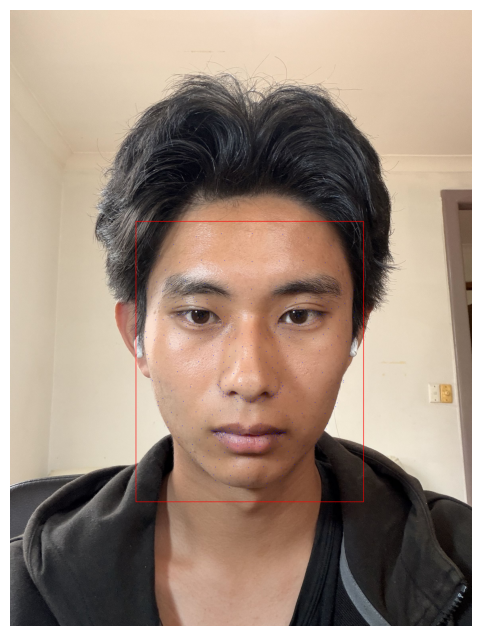

In [ ]:
image_path = "/home/freekitkallos/Downloads/richard_test.jpg"  # set your path here
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
result = face_landmarker.detect(mp_image)

if not result.face_landmarks:
    print("No face detected")
else:
    landmarks = result.face_landmarks[0]
    dbg = draw_overlays(image, result, landmarks,
                        box_color=(0, 0, 255),  # red bbox
                        lm_color=(255, 0, 0))  # blue landmarks
    # Show inline in notebook
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,8))
    plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()